In this notebook we're going to explore the important issue of *windowing* from a rather different direction to what you've probably seen before... and will show you a new way to handle DICOM pixel rescaling that might just give your models a boost!

We'll be using the `fastai.medical.imaging` library here - for more information about this see the notebook [Some DICOM gotchas to be aware of](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai).

In [1]:
!pip install torch torchvision feather-format kornia pyarrow --upgrade   > /dev/null
!pip install git+https://github.com/fastai/fastai_dev                    > /dev/null

from fastai2.basics           import *
from fastai2.medical.imaging  import *

np.set_printoptions(linewidth=120)

ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
  Running command git clone -q https://github.com/fastai/fastai_dev /tmp/pip-req-build-2nj2fym8


In [2]:
path = Path('../input/rsna-intracranial-hemorrhage-detection/')
path_trn = path/'stage_1_train_images'
path_tst = path/'stage_1_test_images'

As discussed in the excellent kernel [See like a Radiologist with Systematic Windowing](https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing) (from which I derived the somewhat cheeky title of this current notebook!), radiologists use *windowing* to increase the contrast of images across particular bands of *hounsfield units*.

But *why* do they do this? It's because the human visual system can only see 100 levels of gradation of a single color (in this case, white/grey/black) - and even fewer with the limitations of a computer display - but there are up to `2**16 == 65536` levels in a 16 bit DICOM image. So a human can't possibly see all those levels at once in a single greyscale image. To see this, let's look at the same image the *See like a radiologist* notebook studies, without any windows:

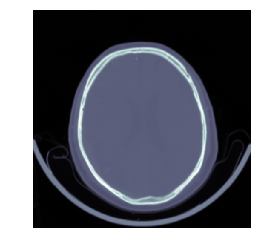

In [3]:
fname = path_trn/'ID_9d9cc6b01.dcm'
dcm = fname.dcmread()
dcm.show(scale=False)

On the other hand, with brain windowing, we can clearly see the details of the brain:

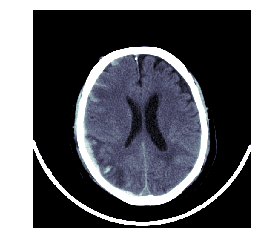

In [4]:
dcm.show(scale=dicom_windows.brain)

**But**, do *computers* need to use windowing? Every kernel I've seen so far, and every person in this competition I've spoken to, are all using windowing. But... computers don't have the problem that their perception systems can only see 100 levels at a time! So, they don't need windowing!

Perhaps, you're thinking, we need to squish the image down into 256 levels so we can put it in an 8-bit image file? Or, like [some folks have demonstrated](https://www.kaggle.com/reppic/gradient-sigmoid-windowing) we could get 3x more levels by using a 3 channel image with different windows in each channel?

Nope, we don't even need to do that! Remember: a neural network takes as input *floating point* data, not integer data. Floats (as used in deep learning libraries) use 32 bits, and give us a high level of precision, particuarly for numbers close to zero. (If you're not familiar with how floats work "under the hood", check out the "Floating point arithmetic" section of [Computational Linear Algebra for Coders](https://github.com/fastai/numerical-linear-algebra/blob/master/nbs/1.%20Why%20are%20we%20here.ipynb) for Dr Rachel Thomas.)

If we use floats, this does mean that we can't read, write, and manipulate our images with the popular PIL python package (which only fully supports 8 bit data). And we can't save it in formats like JPEG, since that's 8 bit too. But we can use OpenCV or fastai.vision, both of which can operate directly on floating point data.

# Rescaling floating point data

Note, however, that this doesn't mean that we can ignore scaling entirely. As shown in detail in [Deep Learning from the Foundations](https://course.fast.ai/part2.html), and particularly [lesson 10](https://course.fast.ai/videos/?lesson=10&t=3641), having well-scaled inputs is really important to getting good results from your neural net training. That means we want to see a good mix of values throughout the range of our data - e.g. something having approximately a normal or uniform distribution. Unfortunately, the pixels in our DICOM above don't show that at all:

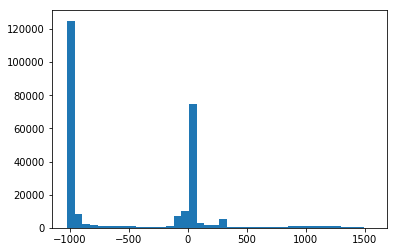

In [5]:
px = dcm.scaled_px.flatten()
plt.hist(px, bins=40);

We see a highly bimodal distribution, with lots of background pixels at around `-1000`, and brain tissue pixels at a bit over `0`. But that's OK, we can normalize this using a simple trick - we can scale our pixel values using a non-linear mapping designed to give us an equal number of pixels in each range. To do that, we first need to split the range of pixel values into groups, such that each group has around the same number of pixels. `fastai` has a method to do this:

tensor([-1024., -1006., -1004., -1003., -1002., -1001., -1000.,  -999.,  -997.,
         -985.,  -960.,  -758.,   -74.,     9.,    24.,    28.,    31.,    34.,
           40.,   227.,   971.,  1469.])


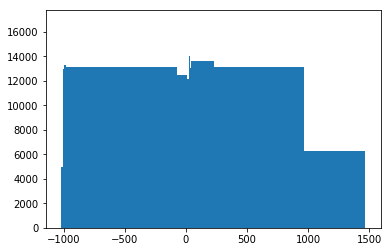

In [6]:
bins = px.freqhist_bins(20)
print(bins)
plt.hist(px, bins=bins);

Because there's some pixel values (like `1024`) which appear many times, we can't get a perfectly uniform result, but it's pretty close. So now we just need a way to scale our pixels evenly using these bins. We can use a simple function which connects these bins with line segments, like this:

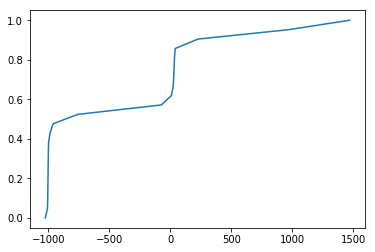

In [7]:
plt.plot(bins, torch.linspace(0,1,len(bins)));

`fastai.medical.imaging` can apply that mapping for you, like so:

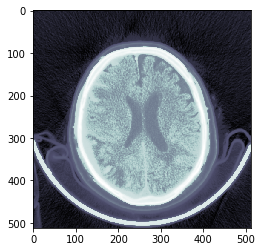

In [8]:
plt.imshow(dcm.hist_scaled(), cmap=plt.cm.bone);

In fact, this is the default way of displaying a DICOM in fastai:

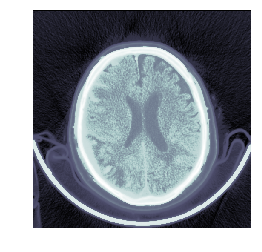

In [9]:
dcm.show()

# Creating a normalized dataset

We can't use this rescaling directly, for one very important reason: the mapping, the way we've defined it, will very from image to image. That means that the pixel values that represent brain tissue, for instance, will be different from image to image. This will be difficult for our neural net to handle. It would be like using different normalization mean and standard deviation for each image, when dealing with normalization in regular image neural nets.

The fix is to create a mapping that is appropriate for a wide range of images. Let's create a mapping from a set of data that represents the three main subgroups we saw in the [Some DICOM gotchas](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai) notebook (see the section "*Looking at metadata - BitsStored and PixelRepresentation*":

To find the appropriate images, we can use the files we created in the notebook [Creating a metadata DataFrame](https://www.kaggle.com/jhoward/creating-a-metadata-dataframe-fastai).

In [10]:
path_inp = Path('../input')
path_df = path_inp/'creating-a-metadata-dataframe-fastai'
df_lbls = pd.read_feather(path_df/'labels.fth')
df_tst = pd.read_feather(path_df/'df_tst.fth')
df_trn = pd.read_feather(path_df/'df_trn.fth')

comb = df_trn.join(df_lbls.set_index('ID'), 'SOPInstanceUID')
repr_flds = ['BitsStored','PixelRepresentation']

These are the 3 subsets we identified in that notebook:

In [11]:
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = comb.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = comb.query('BitsStored==16')
dfs = L(df1,df2,df3)

For each of these subsets, we'll grab a random image with each label, and one with no labels.

In [12]:
htypes = 'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'

def get_samples(df):
    recs = [df.query(f'{c}==1').sample() for c in htypes]
    recs.append(df.query('any==0').sample())
    return pd.concat(recs).fname.values

sample_fns = concat(*dfs.map(get_samples))

Now we will read each of those image files:

In [13]:
sample_dcms = L(Path(o).dcmread() for o in sample_fns)

...and put them in a tensor:

In [14]:
samples = torch.stack(tuple(sample_dcms.attrgot('scaled_px')))
samples.shape

torch.Size([21, 512, 512])

...and get the bins from this set of images:

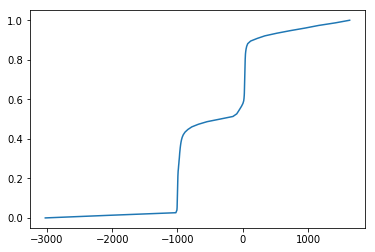

In [15]:
bins = samples.freqhist_bins()
plt.plot(bins, torch.linspace(0,1,len(bins)));

If we pass these bins to `show`, then the image will scale with these bins:

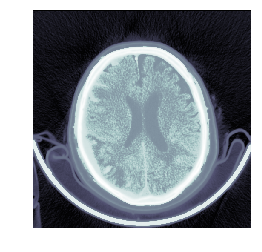

In [16]:
dcm.show(bins)

More importantly, we can pass them to `hist_scaled_px` to get the scaled float tensor, which we can pass to our model:

In [17]:
dcm.hist_scaled(bins)

tensor([[0.0263, 0.0263, 0.0263,  ..., 0.0263, 0.0263, 0.0263],
        [0.0263, 0.0263, 0.0263,  ..., 0.0263, 0.0263, 0.0263],
        [0.1447, 0.1579, 0.1447,  ..., 0.1447, 0.1447, 0.1579],
        ...,
        [0.2632, 0.2632, 0.2588,  ..., 0.1184, 0.1316, 0.1974],
        [0.2697, 0.2697, 0.2807,  ..., 0.1053, 0.1447, 0.2303],
        [0.2697, 0.2807, 0.2928,  ..., 0.1447, 0.1447, 0.2500]],
       dtype=torch.float64)

Note that since this is approximately uniformally distributed between zero and one, it's doesn't have the mean zero, standard deviation one, distribution that our model will want:

In [18]:
scaled_samples = torch.stack(tuple(o.hist_scaled(bins) for o in sample_dcms))
scaled_samples.mean(),scaled_samples.std()

(tensor(0.3993, dtype=torch.float64), tensor(0.3028, dtype=torch.float64))

So all you have to do is to include the `hist_scaled_px` transformation in your model input pipeline, and normalize it to mean zero, standard deviation one. We'll see an example in a future notebook.

# Afterword: a better windowing for humans?

Interestingly, we can use a "rainbow colormap" to fully utilize our computer's ability to display color, our visual system's ability to discern seven million different colors, and our well-distributed normalized pixel data to see an enormous amount of detail in a single image. The image we looked at earlier has a subdural hemorrhage, which you can clearly see as bright purple coloration around the outside of the brain, particulary in the bottom left.

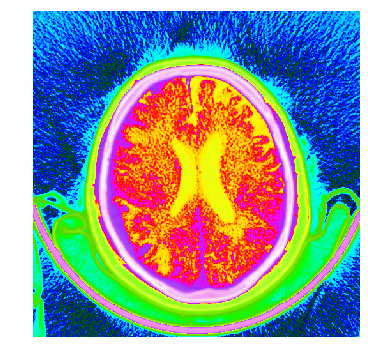

In [19]:
dcm.show(cmap=plt.cm.gist_ncar, figsize=(6,6))

Obviously this color mapping could do with plenty of cleanup (for instance the background should all be black, not a psychodelic pattern!), but the general idea is hopefully clear. I've asked a few radiologists what they think of this approach, and many think it would be a pretty interesting experiment to try out... If any radiologists reading this give it a go, be sure to let me know.